Author : Raphael HASSINE, Student at ISAE-Supaero, date : 01/02/2024

---



# 1/ Context - Fine-tuning, transfer learning and limitations

This Notebook is mainly based on the Deepmind's article : [***Progressive Neural Networks***](https://arxiv.org/abs/1606.04671)

For a long time, including now, training a large Neural-Network model can be really expensive, in terms of cost but also time and complexity. That's why a common approach to develop models is to reuse big models for a specific task. This is called ***Transfer Learning***. One main goal of today's AI innovations is to move toward a ***General AI***, or ***Singularity***. One of today's main challenge is to find a way to train an AI that is capable to perform well on a large variety of tasks, and to ***transfer*** its knowledge to new, yet previously unseen tasks.

What we can often see to achieve that, especially in computer vision, but not only, is Transfer Learning through ***fine-tuning***. How does it work ? Concretely, one should retrieve a ***pretrained*** (PT) model with its trained parameters, and then freeze some parts of the model and only train some relevant features. Classically, in computer vision or NLP, one could retrieve huge models like ResNet, BERT, ELMo or GPT (in practice, so large that impossible to train as a whole for one individual alone), and then fine-tune the last layers of the network to make the model perform well on a specific task (let's say for instance aircrafts recognition).

Let's just illustrate what we just said with transfer learning, and then look if we can meet any limitation about this method.
To do that we'll make great use of this [ContinualAI notebook available here](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

This notebook should preferably be ran on Colab, using a TPU or GPU.

To simplify things and exhibit a specific drawback of transfer learning, we will train our own "weak" model of digits recognition based on the famous MNIST dataset.

In [1]:
#We'll make great use of pytorch, that works better with cuda, so make sure you're using a GPU!
import torch
torch.cuda.is_available()

# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [2]:
#Here are some modules we'll make use of
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#We'll use this script of ContinualAI to load our dataset
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 378 (delta 78), reused 64 (delta 62), pack-reused 258
Receiving objects: 100% (378/378), 26.97 MiB | 31.38 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [4]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


100%|██████████| 9912422/9912422 [00:00<00:00, 60145085.32it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41021230.55it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77118292.99it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7216109.38it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



This dataset is composed of images of ten handwritten digits learning from 60.000, 28x28 grayscale images.

In [5]:
#Let's split our dataset in order to train and evaluate our model later on.
x_train, t_train, x_test, t_test = mnist.load()

#Let's look a little bit how our feature's dimensions look like
print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


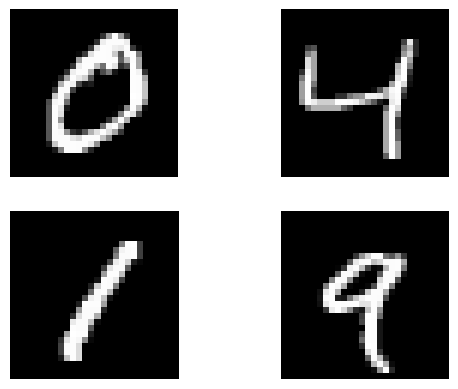

In [7]:
#And now, let's print some images to know what we're dealing with

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Now things are getting serious ! Let's define our first network to classify these digits

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Now let's define our train and test functions

In [10]:
def train_classic(model, device, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test_classic(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Now is time to actually train our network.

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 3):
  train_classic(model, device, x_train, t_train, optimizer, epoch)
  test_classic(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.649760
Test set: Average loss: 0.0013, Accuracy: 9019/10000 (90%)

Train Epoch: 2 	Loss: 0.390873
Test set: Average loss: 0.0007, Accuracy: 9435/10000 (94%)



94% accuracy ! Pretty good. But what's happening if we want to use the same model to recognize digits from a permuted verison of the same MNIST ? Let's write a function that permutes the dataset to find it out.

In [12]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [13]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

starting permutation...
done.


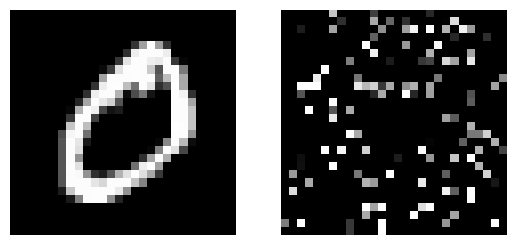

In [14]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Perfect! Let's now see how our model performs.

In [15]:
print("Testing on the first task:")
test_classic(model, device, x_test, t_test)

print("Testing on the second task:")
test_classic(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0007, Accuracy: 9435/10000 (94%)

Testing on the second task:
Test set: Average loss: 0.0108, Accuracy: 1074/10000 (11%)



Of course we get bad performances. We did not finetune our new model with the new data yet. Let's do it!

In [16]:
for epoch in range(1, 3):
  train_classic(model, device, x_train2, t_train, optimizer, epoch)
  test_classic(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 1.623158
Test set: Average loss: 0.0033, Accuracy: 7313/10000 (73%)

Train Epoch: 2 	Loss: 1.298607
Test set: Average loss: 0.0022, Accuracy: 8273/10000 (83%)



Much better ! We get almost the same performances as our first model. Let's now print the two accuracies.

In [17]:
print("Testing on the first task:")
test_classic(model, device, x_test, t_test)

print("Testing on the second task:")
test_classic(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0214, Accuracy: 2513/10000 (25%)

Testing on the second task:
Test set: Average loss: 0.0022, Accuracy: 8273/10000 (83%)



What's... happening ? It looks like training our model on the new task made it kind of "forget" how to manage our old task. This phenomenon is well known as ***Catastrophic forgetting***. We should not be *that* surprised, since we changed our old parameters during backpropagation to handle the new task, we lost some information. Ideally, the network should retain its competence on prior tasks by encoding new informations within sparsely used parameters, or changing important parameters in a way that generalize other takss instead of entirely switching. This is often impossible for standard gradient-based learning not to forget.

![Prognet.png](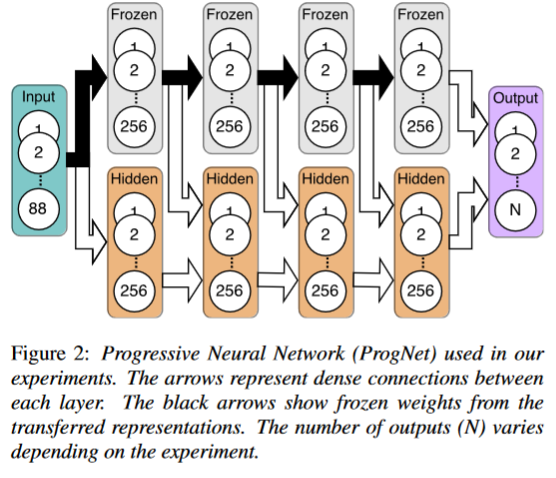![Prognet.png](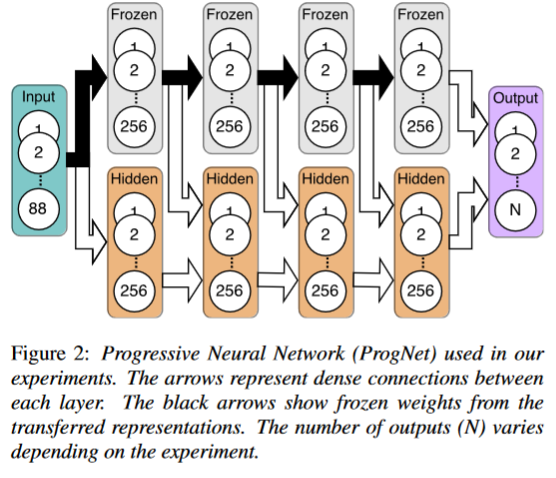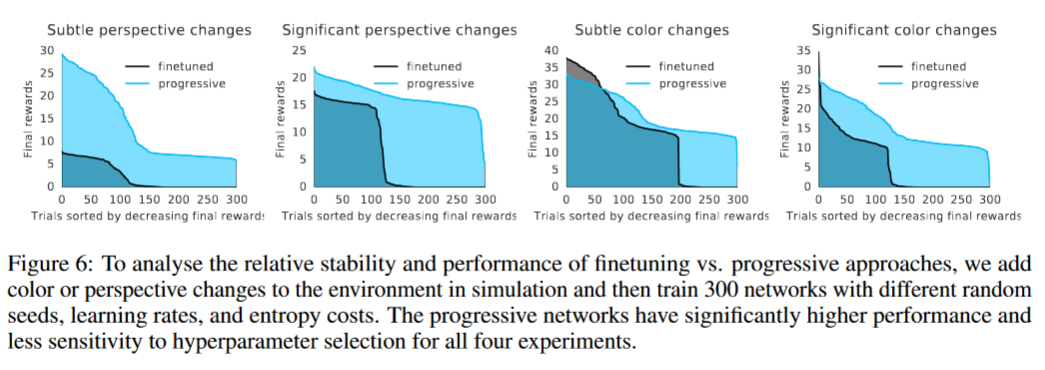))This is a great problem that researchers are still currently trying to adress. And that's exactly what Progressive Networks are about ! They enables transfer learning without catastrophic forgetting by design. How amazing !

# 2/ Introduction to Progressive Networks : definitions, theory

![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1cLyWHy9B1KbaLUsCxyH5YdjIjNiVsRrn)

**What are ProgNets**

According to Deepmind, the creators of ProgNets (which they call Progressive Neural Network, PNN), **PNN** are ***simple, powerful and creative solution to transfer learning, immune to forgetting***. PNN can leverage prio knowledge via lateral connections to previously learnt features. You begin with a single column which will be trained on intial task. ***Every column is made of L blocks, each including layer of neurons W, set of lateral neurons for each parent column U, and activation function f***. Initial column has no incoming lateral connections, so it will act identically to standard network. ***The first column learns task 1, then the parameters are frozen. Then it generates a new column for task 2, and lateral connections are added. It takes as input the outputs of the previous block in all prior columns. Lateral layers are added to the main layer, and then the activation f is applied.***

According to DeepMind, ***each block is a black-box computation that needs to decide which information sources are the most effective for carrying out its task***. If the output block finds that h21 has all the info it needs, it can zero-output other inputs. If it finds h22 and h23 each offer part of needed info, it can ignore h12 and act as a function of h22 and h23.

To summarize, ProgNets consist of

1) ***Freeze all parameters*** of the old model

2) ***Add new model initialized randomly***

3) ***Add connections between old and new model***

4) ***Learn parameters of new model using backpropagation***

![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1B2KdXZJtXY22Qs6vyx7HMvj6qGc9MHFF)

***Comparing PT/FT and ProgNets***

The Pre-training/FT approach is efficient ***when the size of available data of the source domain is abundant compared to data of the target domain*** (for NLP, the English language is more abundant than other languages, so the transfer of english language to others is pretty efficient). Unfortunately, apart from ***catastrophic forgetting*** (parameters for old taks are destructively overwritten), this approach can lead to several other limitations. First of all, transferring learnt parameters between networks can be challenging if the architecture is inconsistent, since the ***topology is fixed***. Second, this paradigm make the assumption of ***overlapping between tasks***, so that the parameters only need to be slightly adjusted to the target domain : we would only need to retrain the top layer.

ProgNets, on the other hand, consist of training a sequence of tasks by ***freezing previously trained tasks and using their intermediate representations as inputs to the new network***. This overcome the ***initialization problem*** (at the expense of added parameters). By design, this architecture ***prevents forgetting*** by freezing and preserving source task weight. One other major advantage is that ProgNets ***make no assumption about relationship between tasks*** (which may be orthogonal or adversarial in practice) by allocating new column for each new task with randomly initialized weights. These columns are free to reuse, modify or ignore via lateral connections(Ui(k,j)). Lateral connections are only from column k to column j : previous columns are not affected by newly learnt features in forward pass. old parameters are kept frozen when training new parameters, which prevent catastrophic forgetting. ProgNets retain a pool of pretrained models throughout training and learn lateral connections from these to extract useful features/tasks (we can see it like our model naturally accumulate experience and is immune to forgetting). This architecture provides a ***richer compositionality*** : prior knowledge is no longer transient and can be integrated at each layer of feature hierarchy. The transfer learning is enabled via lateral connections to features of previously learned columns. Note carefully that the research articles mentionning PNN were not very clear about the nature form of these lateral connections. Some used Linear Layers, but others did use lateral layers the same form of the current module layer. [***This is investigated in this implementation, comparing Linear Layer and LSTM for LSTM blocks.***](https://github.com/khashiii97/Progressive-Neural-Networks-for-IDS/blob/master/src/Blocks.py)

![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1BLf-DaZf2dru_mva5Asz7sMT5EDlzrZ_)

Now, ProgNet should be more understandable for you. It's **time to implement a real one**. For that, we will use a **PyTorch framework called Doric.**

# 3/ First implementation of ProgNets with Doric

[***Doric is a lightweight library for implementing and extending progressive neural networks.***](https://https://github.com/arcosin/Doric) It is a free and open-source library built atop PyTorch.

Doric utilizes user-made blocks to design column networks, which are then generated for new tasks in the prognet. We support inert blocks (blocks without laterals) and multi-channel blocks.

[***This section is greatly inspired by this Medium article.***
](https://towardsdatascience.com/progressive-neural-networks-explained-implemented-6f07366d714d)

As we have seen before, our library requires a definition of blocks. Each block must contain an **activation function**, a **module to act as the block’s main layer**, and a **list of lateral layers to implement the U parameter**s. Doric uses the following **abstract class.**

In [18]:
import torch.nn as nn

"""
Class that acts as the base building-blocks of ProgNets.
Includes a module (usually a single layer),
a set of lateral modules, and an activation.
"""
class ProgBlock(nn.Module):
    """
    Runs the block on input x.
    Returns output tensor or list of output tensors.
    """
    def runBlock(self, x):
        raise NotImplementedError

    """
    Runs lateral i on input x.
    Returns output tensor or list of output tensors.
    """
    def runLateral(self, i, x):
        lat = self.laterals[i]
        return lat(x)

    """
    Runs activation of the block on x.
    Returns output tensor or list of output tensors.
    """
    def runActivation(self, x):
        raise NotImplementedError

    def isLateralized(self):
        return True

Now that we have a **block object**, we need to **organize them into column networks**. These column nets need to be added every time a new task is specified. However, as we have a good extensible block structure, we won’t need to rely on the user to implement individual columns — at least not directly.

In [19]:
"""
A column representing one sequential ANN with all of its lateral modules.
Outputs of the last forward run are stored for child column laterals.
Output of each layer is calculated as:
y = activation(block(x) + sum(laterals(x)))
"""
class ProgColumn(nn.Module):
    def __init__(self, colID, blockList, parentCols = []):
        super().__init__()
        self.colID = colID
        self.isFrozen = False
        self.parentCols = parentCols
        self.blocks = nn.ModuleList(blockList)
        self.numRows = len(blockList)
        self.lastOutputList = []

    def freeze(self, unfreeze = False):
        if not unfreeze:    # Freeze params.
            self.isFrozen = True
            for param in self.parameters():   param.requires_grad = False
        else:               # Unfreeze params.
            self.isFrozen = False
            for param in self.parameters():   param.requires_grad = True

    def forward(self, input):
        outputs = []
        x = input
        for row, block in enumerate(self.blocks):
            currOutput = block.runBlock(x)
            if row == 0 or len(self.parentCols) < 1:
                y = block.runActivation(currOutput)
            else:
                for c, col in enumerate(self.parentCols):
                    currOutput += block.runLateral(c, col.lastOutputList[row - 1])
                y = block.runActivation(currOutput)
            outputs.append(y)
            x = y
        self.lastOutputList = outputs
        return outputs[-1]

Finally, we need the **whole progressive neural network**. This object will contain a list of column nets and will run each necessary column to produce a result for the given task.

In [20]:
import torch.nn as nn
"""
A progressive neural network as described in Progressive Neural Networks (Rusu et al.).
Columns can be added manually or with a ProgColumnGenerator.
https://arxiv.org/abs/1606.04671
"""
class ProgNet(nn.Module):
    def __init__(self, colGen = None):
        super().__init__()
        self.columns = nn.ModuleList()
        self.numRows = None
        self.numCols = 0
        self.colMap = dict()
        self.colGen = colGen
        self.colShape = None

    def addColumn(self, col = None, msg = None):
        if not col:
            parents = [colRef for colRef in self.columns]
            col = self.colGen.generateColumn(parents, msg).to(device)
        self.columns.append(col)
        self.colMap[col.colID] = self.numCols
        self.numRows = col.numRows
        self.numCols += 1
        return col.colID

    def freezeColumn(self, id):
        col = self.columns[self.colMap[id]]
        col.freeze()

    def freezeAllColumns(self):
        for col in self.columns:
            col.freeze()

    def unfreezeColumn(self, id):
        col = self.columns[self.colMap[id]]
        col.freeze(unfreeze = True)

    def unfreezeAllColumns(self):
        for col in self.columns:
            col.freeze(unfreeze = True)

    def getColumn(self, id):
        col = self.columns[self.colMap[id]]
        return col

    def forward(self, id, x):
        x = x.view(-1, 1, 28, 28)
        colToOutput = self.colMap[id]
        for i, col in enumerate(self.columns):
            y = col(x)
            if i == colToOutput:
                return y

In [21]:

"""
Class that generates new ProgColumns using the method generateColumn.
The parentCols list will contain references to each parent column,
such that columns can access lateral outputs.
Additional information may be passed through the msg argument in
generateColumn and ProgNet.addColumn.
"""
class ProgColumnGenerator:
    def generateColumn(self, parentCols, msg = None):
        raise NotImplementedError

Note the importance of this class and its method for the final user : when training its network, ***all he will have to do is make a call to addColumn to add a new task to learn, after having called the freezeAllColumns.***
AddColumn provides **flexibility** to define these columns, since they can **either pass an existing column net directly, or use a costom column generator by inheriting the ProgColumnGenerator class**. We will develop later on the logic to generate columns. This feature however allows the user to **customize the architecture of each column** through the *generateColumn* method, allowing the PNN to **integrate columns seamlessly !**

It is also interesting to note that **forward method is crucial** : the PNN executes **each column sequentially**, **stopping at the column corresponding to the specific task at hand**. This sequential process allows later columns to *access input from each lateral connection.*

In [22]:
class ProgColumn(nn.Module):
    def __init__(self, colID, blockList, parentCols = [], input_dim=0, output_dim=0):
        super().__init__()
        self.colID = colID
        self.isFrozen = False
        self.parentCols = parentCols
        self.blocks = nn.ModuleList(blockList)
        self.numRows = len(blockList)
        self.lastOutputList = []

    def freeze(self, unfreeze = False):
        if not unfreeze:    # Freeze params.
            self.isFrozen = True
            for param in self.parameters():   param.requires_grad = False
        else:               # Unfreeze params.
            self.isFrozen = False
            for param in self.parameters():   param.requires_grad = True

    def forward(self, input):
        outputs = []
        x = input
        for r, block in enumerate(self.blocks):
            y = self._forwardSimple(x, r, block)
            outputs.append(y)
            x = y
        self.lastOutputList = outputs
        return outputs[-1]

    def _forwardSimple(self, x, row, block):
        currOutput = block.runBlock(x)
        if not block.isLateralized() or row == 0 or len(self.parentCols) < 1:
            y = block.runActivation(currOutput)
        else:
            for c, col in enumerate(self.parentCols):
                runLateral = block.runLateral(c, col.lastOutputList[row - 1])
                if runLateral.dim() > 3:
                  runLateral_resized = F.interpolate(runLateral, size=currOutput.shape[2:])
                  currOutput = currOutput+ runLateral_resized
                else:
                  currOutput=currOutput+runLateral
            y = block.runActivation(currOutput)
        return y

Later, we will **use this architecture to learn digits from MNIST**, **a Convolutional 2D Block** will be useful for that. But we will also make use of **Maxpool2D**, **Dropout**, **Dropout2D**, **Linear**(or Dense), and also **flattening**. Not that we could have defined multiple modules in each block (we could have integrated dropout within the Convolutional2D block, but we did'nt for clarity purpose)

In [23]:
"""
A ProgBlock containing a single Conv2D layer (nn.Conv2d).
Activation function can be customized but defaults to nn.ReLU.
Stride, padding, dilation, groups, bias, and padding_mode can be set with layerArgs.
"""

class ProgConv2DBlock(ProgBlock):
    def __init__(self, inSize, outSize, kernelSize, numLaterals, activation = nn.ReLU(), layerArgs = dict(), layerIndex=0):
        super().__init__()
        self.numLaterals = numLaterals
        self.inSize = inSize
        self.outSize = outSize
        self.kernSize = kernelSize
        self.module = nn.Conv2d(inSize, outSize, kernelSize, **layerArgs)

        self.laterals = nn.ModuleList()
        if layerIndex > 0: #we don't want lateral connections on the first layer
            self.laterals = nn.ModuleList([nn.Conv2d(inSize, outSize, kernelSize, **layerArgs) for _ in range(numLaterals)])
        #We can pass an activation argument, it defaults to ReLU, but can be customized

        self.activation = activation

    def runBlock(self, x):
        return self.module(x)

    def runLateral(self, i, x):
        lat = self.laterals[i]
        output = lat(x)
        return output

    def runActivation(self, x):
        return self.activation(x)

class ProgMaxPool2DBlock(ProgBlock):
    def __init__(self, in_channels, kernel_size, numLaterals, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False, layerIndice=0, layerArgs=dict()):
        super().__init__()
        self.module = nn.MaxPool2d(kernel_size, stride, padding, dilation, return_indices, ceil_mode)

        self.laterals = nn.ModuleList([nn.MaxPool2d(kernel_size, stride, padding, dilation, return_indices, ceil_mode) for _ in range(numLaterals)])

    def runBlock(self, x):
        return self.module(x)

    def runActivation(self, x):
        return x

    def runLateral(self, i, x):
        lat = self.laterals[i]
        output = lat(x)
        return output

class ProgDropout2DBlock(ProgBlock):
    def __init__(self, numLaterals, in_channels, out_channels, p=0.5, inplace=False, layerArgs=dict()):
        super().__init__()
        self.module = nn.Dropout2d(p, inplace)
        self.laterals = nn.ModuleList([nn.Dropout2d(p, inplace) for _ in range(numLaterals)])

    def runBlock(self, x):
        return self.module(x)

    def runActivation(self, x):
        return x

    def runLateral(self, i, x):
        lat = self.laterals[i]
        output = lat(x)
        return output

class ProgLinearBlock(ProgBlock):
    def __init__(self, in_features, out_features, numLaterals, bias=True, layerIndex=0):
        super().__init__()
        self.module = nn.Linear(in_features, out_features, bias)
        self.laterals = nn.ModuleList([nn.Linear(in_features, out_features) for _ in range(numLaterals)])

    def runBlock(self, x):
        return self.module(x)

    def runActivation(self, x):
        return x

    def runLateral(self, i, x):
        lat = self.laterals[i]
        output = lat(x)
        return output

class ProgFlattenBlock(ProgBlock):
    def __init__(self, numLaterals):
        super().__init__()
        self.module=nn.Flatten()
        self.laterals = nn.ModuleList([nn.Flatten() for _ in range(numLaterals)])

    def runBlock(self, x):
        return torch.flatten(x, start_dim=1)

    def runActivation(self, x):
        return x

    def runLateral(self, i, x):
        return self.laterals[i](x)

class ProgDropout(ProgBlock):
    def __init__(self, numLaterals, p=0.5, inplace=False):
        super().__init__()
        self.p = p
        self.inplace = inplace
        self.module=nn.Dropout(p)
        self.laterals = nn.ModuleList([nn.Dropout(p) for _ in range(numLaterals)])

    def runBlock(self, x):
        return F.dropout(x, self.p, self.training, self.inplace)

    def runActivation(self, x):
        return x

    def runLateral(self, i, x):
        lat = self.laterals[i]
        output = lat(x)
        return output

Note how all these classes **look like each others.** All we did was **defining their modules, and the list of their lateral connections**. If you read the code well, you now understand that we will **need to specify the number of laterals** during the first instantiation of our block objects.

We defined a **ProgLinearBlock**, but if you read the documentation of Doric, it is referenced as DenseLayer (often implemented with a BatchNorm module also). These modules do basically the **same thing.**

Now is **really important** : we need to **define the logic to generate our network**! We know that we will work on an **MNIST task**, just as we did before, so the **input is size 1x28x28**. Our first layer will be a **Convolution taking 1 channel as input, and outputting 10 channels**. Then we will apply a **Maxpool operation**, with a kernel size of 2, then a **convolutional layer again**. Then we will apply **dropout** (with default p=0.5) to avoid overfitting. Then **maxpool** with kernel=2 again. We will then **flatten** our vector, and pass it to **LinearBlock**. We do **dropout** again, and then the **last layer outputs one of the 10 possible classes**. All the sizes are specified in the code. You should think about it well before constructing your own architecture, **since shapes errors were encountered pretty frequently** during my implementation.

Feel free to **customize this architecture** at will. It is pretty **arbitrary**, and **not optimized at all to maximize the accuracy**. The point here is to **see if this network can be resilient to catastrophic forgetting** in the MNIST context.

Also, note again that **some modules should benefit from being merged together**, like in this implementation example. The choice not to do so was pretty arbitrary also.

In [31]:
class LogicGen(ProgColumnGenerator):
    def __init__(self):
        self.ids = 0

    def generateColumn(self, parentCols, msg = None):


      if len(parentCols) == 0:
          # First column
          #input MNIST is 1x28x28
          a=ProgConv2DBlock(1, 10, 5, 0, layerIndex=0) #output 10x24x24
          b=ProgMaxPool2DBlock(10,2, 0, layerIndice=1) # output 10x12x12
          c=ProgConv2DBlock(10, 20, 5, 0, layerIndex=2) #output 20x8x8
          d=ProgDropout2DBlock(0,20,20) #output 20x8x8
          e=ProgMaxPool2DBlock(10,2, 0, layerIndice=4) #output 20x4x4
          f=ProgFlattenBlock(0) #output 320
          g=ProgLinearBlock(320, 50, 0, layerIndex=6) #output 50
          h=ProgDropout(0) #output 50
          i=ProgLinearBlock(50, 10, 0, layerIndex=8) #output 10 classes

      else:
        #for debugging purpose, since the initialization of the second column was difficult in my case, i did make use of print statements to see when did my column building fail.
        #Feel free to delete the print lines if it bothers you

          print("begginning")
          a=ProgConv2DBlock(1, 10, 5, len(parentCols), layerIndex=0) #output 10x24x24
          print("progconv2d")
          b=ProgMaxPool2DBlock(10,2, len(parentCols), layerIndice=1) #input 10x24x24, output 10x12x12
          print("progmaxpool2d")
          c=ProgConv2DBlock(10, 20, 5, len(parentCols), layerIndex=2) #input 10x12x12, output 20x8x8
          print("progconv2d")
          d=ProgDropout2DBlock(len(parentCols),20,20) #input 20x8x8, output 20x8x8
          print("progdropout2d")
          e=ProgMaxPool2DBlock(20,2, len(parentCols), layerIndice=4) #input 20x8x8, output 20x4x4
          print("progmaxpool2d")
          f=ProgFlattenBlock(len(parentCols)) #input 20x4x4, output 320
          print("progflattent")
          g=ProgLinearBlock(320, 50, len(parentCols), layerIndex=6) #input 320, output 50
          print("proglinear")
          h=ProgDropout(len(parentCols)) #input 50, output 50
          print("progdropout")
          i=ProgLinearBlock(50, 10, len(parentCols), layerIndex=8) #input 50, output 10 classes
          print("proglinear")

      c = ProgColumn(self.__genID(), [a, b, c, d, e, f, g, i], parentCols = parentCols)
      return c

    def __genID(self):
        id = self.ids
        self.ids += 1
        return id

#4/ Using ProgNets for our previous MNIST problem. Comparing this approach to PT/FT

Now **we're done** ! All things should be set. Just as we did before we wil declare a **train and test functions**, that work pretty much like the classic ones, except that we wille need to **specify each column we would like to train and test (column_id)**

In [32]:
def train_prognet(model, device, x_train, t_train, optimizer, epoch, column_id):
    model.train()

    for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0), -1)

        optimizer.zero_grad()

        output = model(column_id, x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()

    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Let's do it ! We will first **instantiate our network**, then **adding the first column to it**, then **declaring our optimizer**, and **finally training it for 20 epochs** (arbitrary)

Note that you **should run it on a GPU** since the training can take some time on any CPU. The **first taks is pretty easy to learn**, but that is **not the case for the second one**, that is more difficult, and will need a **greater number of epochs to converge.**



In [33]:
EPOCHS=20
net = ProgNet(colGen = LogicGen()).to(device)
id1 = net.addColumn()
optimizer = optim.SGD(net.parameters(), lr = 0.01)
print("Training Task1.")
for i in range(EPOCHS):
    train_prognet(net, device, x_train, t_train, optimizer, i, id1)

Training Task1.
Train Epoch: 0 	Loss: 2.225050
Train Epoch: 1 	Loss: 1.257945
Train Epoch: 2 	Loss: 0.804736


Now, let's **evaluate** if it was well trained. Let's declare our **test method**.

In [28]:
def test_prognet(model, device, x_test, t_test, column_id):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
        end = start + 256
        with torch.no_grad():
            x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
            x, y = x.to(device), y.to(device)
            x = x.view(x.size(0), -1)
            output = model(column_id, x)
            test_loss += F.cross_entropy(output, y).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max logit
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [29]:
print("Testing Task 1.")
test_prognet(net, device, x_test, t_test, id1)

Testing Task 1.
Test set: Average loss: 0.0019, Accuracy: 8738/10000 (87%)



87.38

Since I do not own a GPU, i ran it for only **3 epochs, and got 87% accuracy.** Pretty neat. It should be greater on your harware. Anyway, that is not the point.

Just like we did before, we **permute** with the same function as before the train and test set. We then **freeze all columns** (we could just have frozen id1, but anyway, since all columns are frozen, **when you create a new one, that's the only one that will learn**. You can verify this with the **require_grad** attribute).

The second task is **more difficult**, and is **built atop the first one**. For this reason, you should consider **increasing the number of epochs**, and **finetuning a little bit the learning rate** of your optimizer. Note also that it is a good idea to **instantiate a new optimizer**, since the **old parameters are sometimes kept in the memory** of the object, and that could **interfere with the learning** of the new task.

In [34]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)
net.freezeAllColumns()
id2 = net.addColumn()
optimizer = optim.SGD(net.parameters(), lr = 0.01)

print("Training Task2.")
for i in range(EPOCHS+10):
    train_prognet(net, device, x_train2, t_train, optimizer, i, id2)


starting permutation...
done.
begginning
progconv2d
progmaxpool2d
progconv2d
progdropout2d
progmaxpool2d
progflattent
proglinear
progdropout
proglinear
Training Task2.
Train Epoch: 0 	Loss: 1.959594
Train Epoch: 1 	Loss: 1.816528
Train Epoch: 2 	Loss: 1.836754
Train Epoch: 3 	Loss: 1.750811
Train Epoch: 4 	Loss: 1.928767


Now is time for the truth moment ! Let's see how our model performs on both tasks

In [35]:
# Utilisation de la fonction
print("Testing Task 2.")
test_prognet(net, device, x_test2, t_test, id2)
print("Testing Task 1")
test_prognet(net, device, x_test, t_test, id1)

Testing Task 2.
Test set: Average loss: 0.0045, Accuracy: 6360/10000 (64%)

Testing Task 1
Test set: Average loss: 0.0019, Accuracy: 8571/10000 (86%)



85.71

**Bingo** ! How satisfying huh ? We could **add an infinite number of columns**, generalizing to an **infinite number of tasks**, modulo the **resources and computational power** availability. Let's look at how our model look like.

In [36]:
net

ProgNet(
  (columns): ModuleList(
    (0): ProgColumn(
      (blocks): ModuleList(
        (0): ProgConv2DBlock(
          (module): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
          (laterals): ModuleList()
          (activation): ReLU()
        )
        (1): ProgMaxPool2DBlock(
          (module): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (laterals): ModuleList()
        )
        (2): ProgConv2DBlock(
          (module): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
          (laterals): ModuleList()
          (activation): ReLU()
        )
        (3): ProgDropout2DBlock(
          (module): Dropout2d(p=0.5, inplace=False)
          (laterals): ModuleList()
        )
        (4): ProgMaxPool2DBlock(
          (module): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (laterals): ModuleList()
        )
        (5): ProgFlattenBlock(
          (module): Flatten(start_dim=1, end_dim=-1)
      

#5/ Other current uses of ProgNet


Here we demonstrated the power of PNN for digit MNIST recognition. But this is just the tip of the iceberg, since PNN are widely used on other fields of research. [**This repository use the same Doric implementation as we just did to perform Intrusion-Detection-System (IDS) tasks, using Long-Short-Term-Memory (LSTM) Blocks.** ](https://https://github.com/khashiii97/Progressive-Neural-Networks-for-IDS/tree/master/src)

[**This article highlights the usefulness of PNN to implements Variational Auto-Encoders (VAEs) and Autoencoders applied to the CelebA dataset**](https://towardsdatascience.com/progressive-neural-networks-explained-implemented-6f07366d714d), managing a large variety of tasks, such as :

1.   **Reconstruing** the input images as the output, preserving important information

2.   **Denoising** — removing salt-and-pepper noise from the input.

3.   **Colorizing** — adding color to a gray scale version of the input.

4.   **Inpainting** — painting in a portion of the image that has been occluded by a random walk of black pixels.

**Their results are pretty impressive !**

![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1kltaIcvbu6t_968JtpDNXML1UcTi7JCT)


![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1U73DyvAEH8Cd1i5SleFVePXlNZp4wUx_)

![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1G7u8-Uq1Zyk8iwKniWtNwoZIdJqnmcIx)




---



[**In their 2016 fundamental article**,](https://https://arxiv.org/pdf/1606.04671.pdf) Deepmind's research team also demonstrated the efficiency of PNN in order to perform Transfer Learning on reinforcement-learning tasks:

1.  **Pong** variants include flipped, noisy, scaled, and recoloured
transforms;

2. **Labyrinth** is a set of 3D maze games with diverse level maps and diverse positive and negative reward items;

3. **Atari games** for a more challenging setting for transfer

Basically, they trained each column to solve a particular Markov Decision Process (MDP) : the kth column defines a policy, taking as input a state s given by the environement, and generating probabilities over actions. At each time step, an action is sampled from this distribution, and taken in the environement, yielding the subsequent state.

We will not dive further into details here, but if you're curious, you can read their article (actually, that would be **a must** if you want to dig into PNNs)



---



DeepMind seems really interested with PNNs in **reinforcement-learning** context, since they published a **second research paper in 2017**, highlighting the possible use of ProgNets for [**Sim-to-Real Robot Learning from Pixels with
Progressive Nets**](https://arxiv.org/pdf/1610.04286.pdf). In order to teach robots how to behave, since real-world experiments are really expensive (in time) to achieve, but not simulations, this paper propose to use simulations for column 1, and then transfer the column 1 in simulation to column 2 in real world, bridging what they call **the reality gap**

![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1ao8lQvfk_GmtjN8urEFW6gVOUvOBJWzW)

![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=18M46Lm_sIqQuL1cJQBM8x91CZ9qoMt3T)





---



At last but not least, [**This collaboration between IBM and the University of Michigan also demonstrates the powerfulness of PNNs**](https://https://arxiv.org/pdf/1706.03256.pdf) performing **Neuro-Linguistic Programming (NLP)** tasks, especially **emotion recognitions**  (since emotions are complex and multi-factorials, transfer learning is important and PNNs demonstrated to work better in these context of really complex tasks). This article explores the utility of **transferring knowledge across both paralinguistic task and dataset simultaneously**, even when the dataset has **different characteristics** (for instance telphone and high fidelity speech). Speech recognition datasets tends to contain more training utterances than emotion datasets, and contain paralinguistic informations, such as subject IDs. Data could be used to train classifiers for different types of speaker (accent, demographics). Then, this could be transferred to emotion account for **person-specific variations tied to phenomena outside of emotion.** This could **better augment emotion classifications with already existing data. **

It is short, well written and explained, maybe even better than the Deepmind's article, so feel free to read it (some illustrations in this notebook come directly from this paper).




#6/ Limitations of ProgNets


---
We demonstrated the power of PNNs, so they're **perfect**, right ? Actually, **not quiet**. There are some several **drawbacks** that we should investigate before concluding this notebook.

First of all, PNNs kind of **waste some parameter**s, since each lateralized block requires full lateral layer for each parent columns it draws from. **Only a fraction of the new capacity is actually utilized**, and the trend increases with more columns. This leads to a **growth in the number of parameters and tasks** (facing the main limitation : computational power). This can be adressed by adding fewer layers, or less capacity to the network (for instance, using pruning or online compression during learning).

PNNs are also limited by the fact that they **only perform on data where each record has a corresponding label** (no semi-supervised and unsupervised learning possible).

To allow freezing, **each task must be learnt sequentially**, enlarging the time cost. But this is not the worst! The **sequence order of the tasks learnt can drastically affect the quality of resultant net** ! In our example, try to learn task 2 before task 1, and you'll see some drastic changes in accuracy. Also, due to freezing, the architecture is **not flexible if a task change**, since columns must be extremely adept in their task before freezing.
Actually, it looks like  PNNs introduce a ***tradeoff between model complexity (since there are more parameters to train), and the flexibility on changing tasks.***

The last limitation looks pretty neat : **how do we know which column to use for inference without knowledge of the task label ?** We can imagine combining this architecture with other unsupervised/clustering models in order to know which column to select.

#7/ Discussion and improvements : the future of ProgNets

We could further **improve our current implementation** of Progressive Networks. Doric provides **several other classe**s, such as **Inert Blocks and Lambda Blocks. **

**Inert blocks** are ones that could be lateralized (not in the initial column nor the first row), but are **intentionally left unlateralized**. These allows to include **special operations** in the network, or to **reduce unnecessary parameters** in blocks that aren't greatly benefiting by transfer learning. They are really **easy to implement**, only declaring this short class :


In [ ]:
class ProgInertBlock(ProgBlock):
    def isLateralized(self):
        return False

For **lambda/multi blocks**, we mentioned them briefly during our tutorial : these are blocks that **computes few transformation on input before outputing the lateral connections** (such as dropout for instance).

To implement this change, we should first **implement a multiblock class**, and then we should **modify the ProgColumn class**. We should modify the forward method in order to pass a either a **simple Forward**, or a **multi forward**, as we can see here :

In [ ]:
"""
A special case of ProgBlock with multiple paths.
"""
class ProgMultiBlock(ProgBlock):
    """
    Returns a list of booleans (pass_list).
    Length of the pass_list is equal to the number of channels in the block.
    Channels that return True do not operate on their inputs, and simply pass them to the next block.
    """
    def getPassDescriptor(self):
        raise NotImplementedError

class ProgColumn(nn.Module):
    def __init__(self, colID, blockList, parentCols = []):
        super().__init__()
        self.colID = colID
        self.isFrozen = False
        self.parentCols = parentCols
        self.blocks = nn.ModuleList(blockList)
        self.numRows = len(blockList)
        self.lastOutputList = []

    def freeze(self, unfreeze = False):
        if not unfreeze:    # Freeze params.
            self.isFrozen = True
            for param in self.parameters():   param.requires_grad = False
        else:               # Unfreeze params.
            self.isFrozen = False
            for param in self.parameters():   param.requires_grad = True

#HERE
    def forward(self, input):
        outputs = []
        x = input
        for r, block in enumerate(self.blocks):
            if isinstance(block, ProgMultiBlock):
                y = self._forwardMulti(x, r, block)
            else:
                y = self._forwardSimple(x, r, block)
            outputs.append(y)
            x = y
        self.lastOutputList = outputs
        return outputs[-1]

#HERE
    def _forwardSimple(self, x, row, block):
        currOutput = block.runBlock(x)
        if not block.isLateralized() or row == 0 or len(self.parentCols) < 1:
            y = block.runActivation(currOutput)
        else:
            for c, col in enumerate(self.parentCols):
                currOutput += block.runLateral(c, col.lastOutputList[row - 1])
            y = block.runActivation(currOutput)
        return y

#HERE
    def _forwardMulti(self, x, row, block):
        currOutput = block.runBlock(x)
        if not block.isLateralized() or row == 0 or len(self.parentCols) < 1:
            y = block.runActivation(currOutput)
        else:
            for c, col in enumerate(self.parentCols):
                lats = block.runLateral(c, col.lastOutputList[row - 1])
                for i, p in enumerate(block.getPassDescriptor()):
                    if not p:   currOutput[i] += lats[i]
            y = block.runActivation(currOutput)
        return y



---


We discussed earlier about the **difficulty to choose adequate lateral connections**. This should be further investigated by academic papers in order to better understand what we should use.

---


![Progressive Neural Networks illustrated](https://drive.google.com/uc?export=view&id=1ao8lQvfk_GmtjN8urEFW6gVOUvOBJWzW)

Remember this sketch ? Maybe back then you wondered what this the little grey box with an "a" inside were for. Well, this is because we did not develop long enough about **adapter layers**. This is the name given to the non-linear lateral connections we used earlier on. They**improve intial conditioning, and perform dimensionality reduction**. In **dense layers**, one could **replace linear lateral connections with a single hidden layer Multi-Layer-Perceptron (MLP)**. Before feeding lateral activations into MLP, DeepMind did multiply them by a learnt scalar, initialized by a random value. **Their role is to adjust differents scales or different inputs.** Hidden Layer of nonlinear adapters is a projection onto a n(i) dimensional subspace. As index k grows, this ensures the **number of parameters stemming from lateral connections is the same order as |O(1)|.**



---
That's it ! If you have any question or remark, you can contact me
raphael.hassine@student.isae-supaero.fr
---